<a href="https://colab.research.google.com/github/pumazzo/AIPHY24/blob/main/UncertaintyQuantification_HndsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uncertainty Quantification on Deep Neural Networks#
##Tutorial - Hands-on##

**Scope:** compare different uncertainty quantification methods

**Tasks:** <p>
given the 1D dataset described in the lecture (see first cell code):

1.   train a **BNN based on variational Inference** to solve the 1D regression task and compare the obtained uncertainty bounds with respect to the ones obtained with Pyro using a MCMC sampler with Hamiltonian No-U-trun MC kernel (described in the lecture);
2.   implement a **deep ensamble method** (point estimated ANN models with same archietcture as the BNN) to estimate the uncertainty and compare with the Bayesian result in terms of uncertainty bounds and computational cost;
3.   take the first ANN model trained in point 2 as a black-box, and use **conformal prediction** to assess the model uncertainty. Compare results with previous methods.

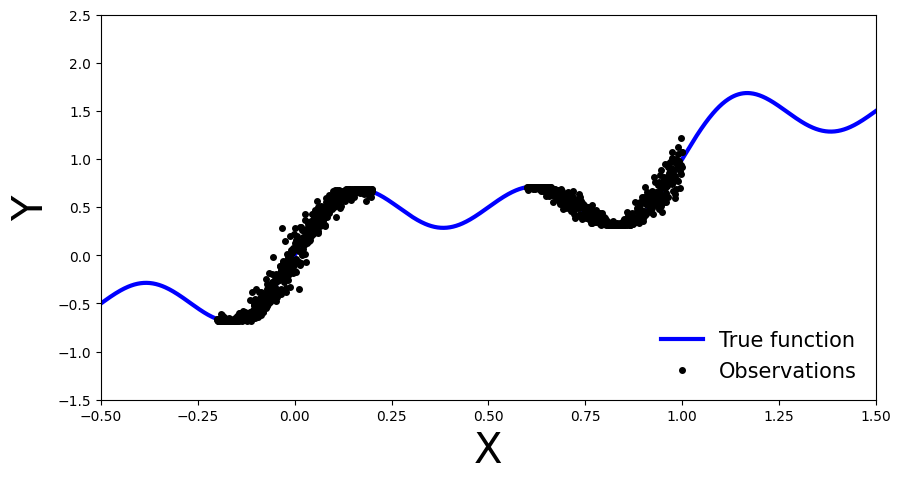

In [1]:
# Create a toy dataset: a set of point generated according a given function + noise
# we generate trainign point in two separate intervals of the function domain to test uncertainty
# quantification for a NN for IID and OOD (interpplation and extrapolation regimes) data
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data

n_data = 500 #half the number of data point

x_obs = np.hstack([np.linspace(-0.2, 0.2, n_data), np.linspace(0.6, 1, n_data)])   #observed features (two not-overlapping sets of the function domain)

noise_scale = 0.02
noise = noise_scale * np.random.randn(x_obs.shape[0]) #gaussian noise

# Generate target variable
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

# Generate true function (eg function w/o noise)
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create function and observed data plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

# Train a Bayesian-DNN model (simple MLP) to predict the values of the function

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from imageio import imread

In [3]:
#install pyro library
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.9 MB/s eta 0:00:00


In [4]:
# BNN trained with variational Inference

# see: http://pyro.ai/examples/intro_long.html#Inference-in-Pyro for details in Pyro usage

# Bayesian DNN Model: MLP with two hidden layers with hid_dim neurons and Tanh activation

# gaussian priors on the weights: N(mu=0, sigma^2=10*I)
# prior for sigma^2: Gamma(0.5,1) (picked distribution at zero)


import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class SimpleBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()

        # PyroModule is a subclass of nn.torch.Module with atributes that can be modified by Pyro
        # PyroMdule[nn.Linear] create a new class that subclasses PyroModule and and torch Linear: eg a Bayesian Linear layer
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)   # first hidden layer [in_dim --> hid_dim]
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # second hidden layer [hid_dim --> out_dim]

        # Set layer parameters as random variables (this makes the layers Bayesian) by using PyroSample which allows to define a prior
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

        # NOTE: while trorch tensors have only one single shape attribute (.shape), Pyro Distributions have two shape attributes (.batch_shaoe and .event_shape)
        # Indices over .batch_shape denote conditionally independent random variables, whereas indices over .event_shape denote dependent random variables (ie one draw from a distribution).
        # In standard Pyro usage dimensions are typically declarted as dependent even though they will be in fact independent, postponing later on to define if the dimensions will be dependent like in
        # a MulitivariateNormal distribution for example or independent (like in this example)

    def forward(self, x, y=None):
        x = x.reshape(-1, 1) #reshape input feature tensor from (batch) to (batch,1)
        x = self.activation(self.layer1(x)) #apply first layer + activation transform

        mu = self.layer2(x).squeeze() #apply second layer (no activation)
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model (pyro.plate allows to define dimensions as conditytionally independent as in our model)
        # Remember in Pyro samples have shape batch_shape + event_shape, whereas .log_prob(x) values have shape batch_shape,
        # pyro.plate allows to take care of that
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [5]:
# train model with Variational Inference
# for more details : http://pyro.ai/examples/intro_long.html
# stochastic variational inference with the variational density q by using a normal probability density with a diagonal covariance matrix

from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store() #set the initial pyro parameters store

model = SimpleBNN()

# "guide" in the pyro lingo is the variational distribution q. AutoDiagonalNormal is normal q with diagonal cov. matrix
# https://docs.pyro.ai/en/stable/infer.autoguide.html
mean_field_guide = AutoDiagonalNormal(model)# mean field, each variable in independent (i.e diagonal correlation matrix)

optimizer = pyro.optim.Adam({"lr": 0.01})

# SVI is the main stochastic variation inference module than encpasule the machinery for doing variational inference
# user needs to provide three things: the model, the guide, and an optimizer
# the ELBO loss is called Trace_ELBO()

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store() #set the initial pyro parameters store

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# training
num_epochs = 10000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
# Now we can use the model in prediction
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)

# test the model over the full function domain range
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [7]:
print(model(x_test).shape)                 # NOTE, this is not what I want, what I want is the model response given a sample of the q distribution
print(preds['obs'].detach().numpy().shape) # for each point in x , 500 samples

torch.Size([3000])
(500, 3000)


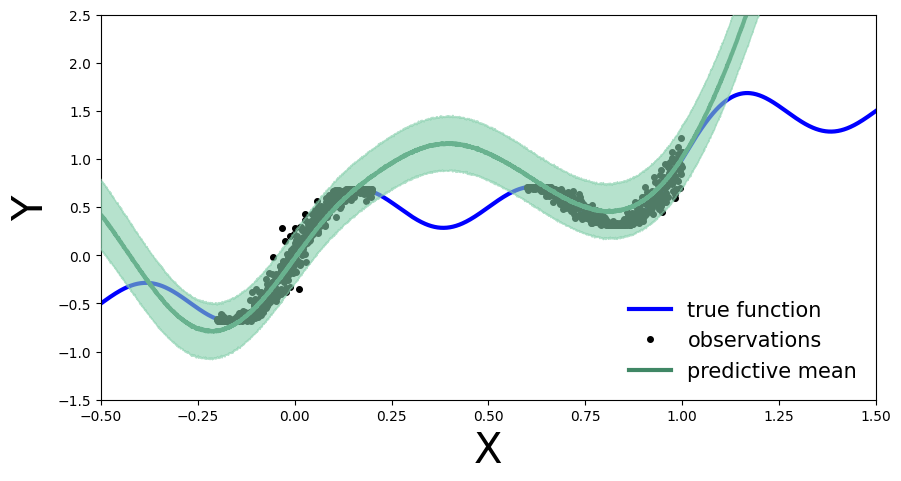

In [8]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1) #predictions mean
    y_std = preds['obs'].T.detach().numpy().std(axis=1)   #predictions std. dev.

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, alpha=0.6, color='#86cfac', zorder=5) #95% bands

    plt.legend(loc=4, fontsize=15, frameon=False)


plot_predictions(preds)

# Deep Ensamble Method

Train the same MLP multiple time with different initializations of weigth matrices, use the distribution of the models' predictions for a given input $x$ to estimate mean and std. dev. prediction.

In [9]:
# The non-Bayesian equivalent of the SimpleBNN model
class SimpleNN(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
        super().__init__()

        self.activation = nn.Tanh() #nn.ReLU() #nn.Tanh()  # or nn.ReLU()
        self.layer1 = nn.Linear(in_dim, hid_dim)   # Input to hidden layer
        self.layer2 = nn.Linear(hid_dim, out_dim)  # Hidden to output layer

    def forward(self, x):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()

        return mu

In [10]:
# train loop function

def train_model(model, x, y):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y, model(x))
        progress_bar.set_postfix(loss=f'{loss:.3f}')
        loss.backward()
        optimizer.step()
    return model

In [11]:
# a single ANN result

from tqdm.auto import trange

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
x_test = torch.linspace(xlims[0], xlims[1], 3000)


model = SimpleNN()
model = train_model(model, x_train, y_train)

# test it
preds = model(x_test).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

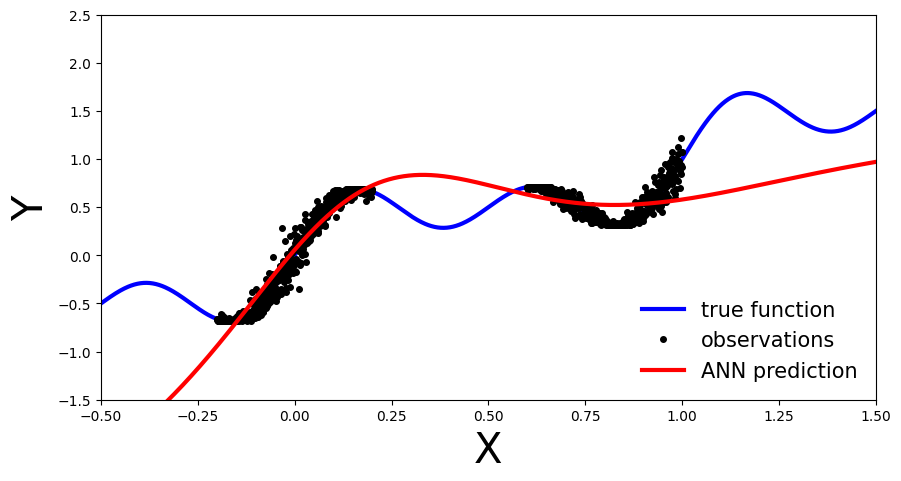

In [12]:
def plot_predictions2(preds):
    y_pred = preds

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, 'r-', linewidth=3, label="ANN prediction")

    plt.legend(loc=4, fontsize=15, frameon=False)


plot_predictions2(preds)

In [13]:
# Deep Ensamble: eg train an ensamble of SimpleNN models each one initalized with different random wights and biases

ensemble_size = 10
ensemble = [SimpleNN() for _ in range(ensemble_size)]
for model in ensemble:
    train_model(model, x_train, y_train)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [14]:
# calculate predictions

ens_preds = [np.array(model(x_test).clone().detach().numpy()) for model in ensemble]

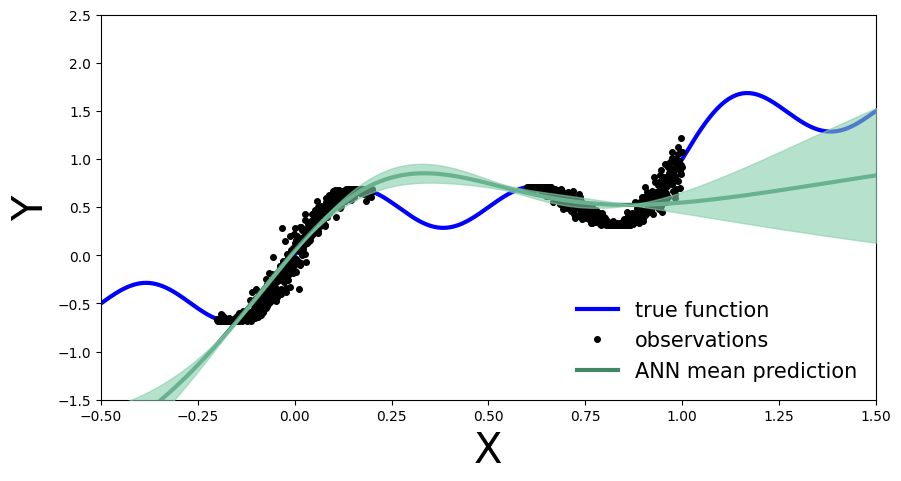

In [15]:
# plot uncertainty bands

def plot_predictions3(ens_preds):
    y_pred = np.array(ens_preds)
    y_mean = y_pred.mean(axis=0)
    y_std = y_pred.std(axis=0)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="ANN mean prediction")
    ax.fill_between(x_test.ravel(), y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, alpha=0.6, color='#86cfac', zorder=5) #95% bounds

    plt.legend(loc=4, fontsize=15, frameon=False)


plot_predictions3(ens_preds)

### NOTE it is possible to do a much better jobs by using a more expressive model (more layers in the MLP with a larger number of neurons in the hidden layers (note: this will take more time to train)

# UQ using Conformal Prediction

* create a calibration dataset (statistically idependent from the training and test set)
* calculate the 95% quantiles
* plot predictions and errro bars for the test set

In [16]:
# split the traing dataset in real training set (80%) and in the calibrations set (20%)

# equally spaced indexes for 20% of the x_train events
cal_idx = np.arange(len(x_train), step=1/0.2, dtype=np.int64)

# selection mask
mask = np.zeros(len(x_train), dtype=bool)
mask[cal_idx] = True

x_cali, y_cali = x_train[mask], y_train[mask]
x_train2, y_train2 = x_train[~mask], y_train[~mask]

print(x_train2.shape)
print(x_cali.shape)

torch.Size([800])
torch.Size([200])


In [17]:
# Train one of the previous models used in the Ensamble case

model = SimpleNN()
model = train_model(model, x_train2, y_train2)

# test it
preds = model(x_test).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

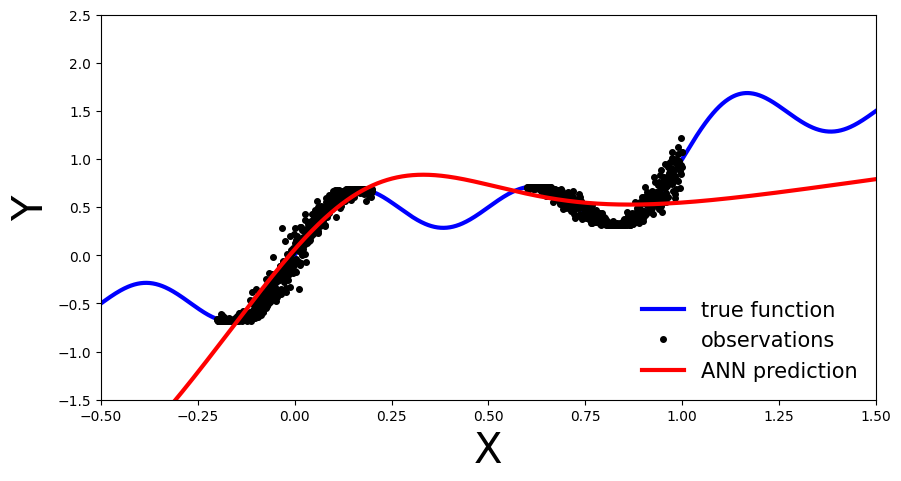

In [18]:
plot_predictions2(preds)

In [19]:
# perform the conformal prediction procedure

#1 compute calibration residuals |true - predicted| = Score
y_cali_preds = model(x_cali).clone().detach()
resid = torch.abs(y_cali - y_cali_preds).numpy()

#2 compute (1-alpha)-quantile (alpha = 5%)of score: P(x<=q) = 1-alpha and P(x>=q) = alpha
alpha = 0.05
n = len(x_cali)
q_val = np.ceil((1 - alpha) * (n + 1)) / n
q = np.quantile(resid, q_val)

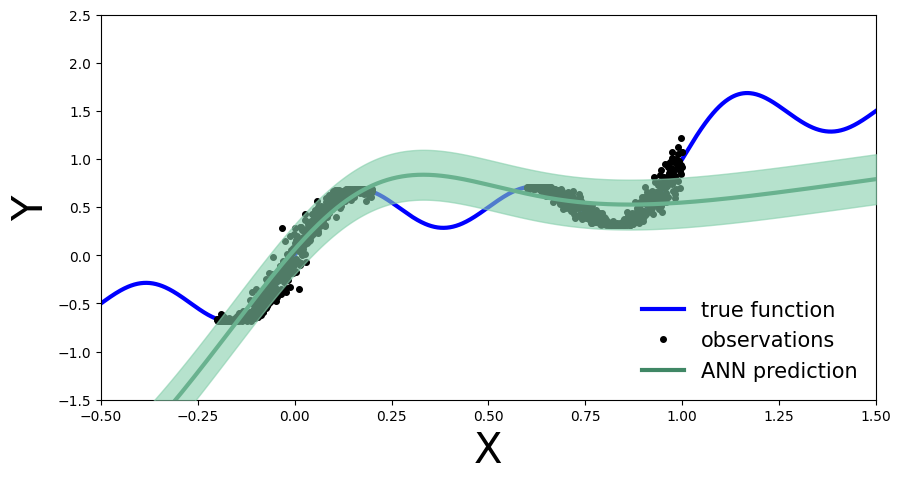

In [20]:
# plot results

def plot_predictions4(preds):
    y_pred = preds

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="ANN prediction")
    ax.fill_between(x_test.ravel(), y_pred - q, y_pred + q, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)


plot_predictions4(preds)

**Suggested exercise:** repeat everything with deeper NNs / change activations functions etc.